Name: Marcos David Madrigal Albores

Student #: 1004731347

In [127]:
%%shell
jupyter nbconvert --to html /content/Lab_4_Data_Imputation_MDMA.ipynb

[NbConvertApp] Converting notebook /content/Lab_4_Data_Imputation_MDMA.ipynb to html
[NbConvertApp] Writing 486017 bytes to /content/Lab_4_Data_Imputation_MDMA.html


# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Mon, March 01, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius <christopher.lucasius@mail.utoronto.ca>

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1P5_4HkW5JERZy1CNZ_ywx_21x8FoJ5RP?usp=sharing


In [27]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [28]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [33]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [34]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [35]:


#For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value


#Get min, max, avg for ach column
min = df.min()
max = df.max()
avg = df.mean()
min_age = min['age']
min_yredu = min['yredu']
min_capgain = min['capgain']
min_caploss = min['caploss']
min_workhr = min['workhr']
max_age = max['age']
max_yredu = max['yredu']
max_capgain = max['capgain']
max_caploss = max['caploss']
max_workhr = max['workhr']
avg_age = avg['age']
avg_yredu = avg['yredu']
avg_capgain = avg['capgain']
avg_caploss = avg['caploss']
avg_workhr = avg['workhr']

print("Max age: ",max_age)
print("Min age: ",min_age)
print("Avg age: ",avg_age)
print("Max yredu: ",max_yredu)
print("Min yredu: ",min_yredu)
print("Avg yredu: ",avg_yredu)
print("Max capgain: ",max_capgain)
print("Min capgain: ",min_capgain)
print("Avg capgain: ",avg_capgain)
print("Max caploss: ",max_caploss)
print("Min caploss: ",min_caploss)
print("Avg caploss: ",avg_caploss)
print("Max workhr: ",max_workhr)
print("Min workhr: ",min_workhr)
print("Avg workhr: ",avg_workhr)


#Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1 (modify the actual df)
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records
print(subdf[:3])

normalize = ['age', 'yredu', 'capgain', 'caploss', 'workhr'] 
for item in normalize:
  normal = max[item]-min[item]
  df[item] = (df[item]-min[item])/normal

subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records
print(subdf[:3]) # show the first 3 records


Max age:  90
Min age:  17
Avg age:  38.58164675532078
Max yredu:  16
Min yredu:  1
Avg yredu:  10.0806793403151
Max capgain:  99999
Min capgain:  0
Avg capgain:  1077.6488437087312
Max caploss:  4356
Min caploss:  0
Avg caploss:  87.303829734959
Max workhr:  99
Min workhr:  1
Avg workhr:  40.437455852092995
   age  yredu  capgain  caploss  workhr
0   39     13     2174        0      40
1   50     13        0        0      13
2   38      9        0        0      40
        age     yredu  capgain  caploss    workhr
0  0.301370  0.800000  0.02174      0.0  0.397959
1  0.452055  0.800000  0.00000      0.0  0.122449
2  0.287671  0.533333  0.00000      0.0  0.397959


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [36]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,0.301370,0.800000,0.02174,0.0,0.397959
1,0.452055,0.800000,0.00000,0.0,0.122449
2,0.287671,0.533333,0.00000,0.0,0.397959


Numpy works nicely with pandas, like below:

In [37]:
np.sum(subdf["caploss"])

652.5941230486685

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
#ok

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [42]:
# hint: you can do something like this in pandas
male_number = sum(df["sex"] == " Male")
fem_number = sum(df["sex"] == " Female")
totalppl = fem_number + male_number
#print(male_number)
#print(fem_number)
#print(totalppl)
percent_female = 100*(fem_number/totalppl)
percent_male = 100*(male_number/totalppl)
print("Female percentage: ",percent_female, "%")
print("Male percentage: ",percent_male, "%")

Female percentage:  33.07945087681583 %
Male percentage:  66.92054912318419 %


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [43]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [44]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [47]:
not_missing= df_not_missing.shape
missing = df_with_missing.shape

percent_not_missing = 100*(not_missing[0]/totalppl)
percent_missing = 100*(missing[0]/totalppl)

print("# of records with no missing features: ",not_missing[0])
print("# of records with missing features: ",missing[0])

print("Stayed/not missing: ",percent_not_missing, "%")
print("Removed/missing: ",percent_missing, "%")

# of records with no missing features:  30718
# of records with missing features:  1843
Stayed/not missing:  94.33985442707534 %
Removed/missing:  5.660145572924664 %


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [49]:
results = set()
df_not_missing['work'].str.lower().str.split().apply(results.update)
print(results)

{'private', 'state-gov', 'without-pay', 'local-gov', 'self-emp-not-inc', 'federal-gov', 'self-emp-inc'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [50]:
data = pd.get_dummies(df_not_missing)

In [51]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [54]:
data_shape = data.shape
print ("Number of rows", data_shape[0])
print ("Number of columns", data_shape[1])
#The new number of columns(features) comes from the one-hot encoding of all the fields that were not numbers (like words, etc), essentially increasing the number of 
#features

Number of rows 30718
Number of columns 57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [55]:
datanp = data.values.astype(np.float32)

In [61]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
    Examples:
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    max_value_index = np.argmax(onehot)
    possible_values = cat_values[feature]
    final_value = possible_values[max_value_index]
    return final_value



In [62]:
cat_index

{'edu': 33,
 'marriage': 12,
 'occupation': 19,
 'relationship': 49,
 'sex': 55,
 'work': 5}

In [63]:
cat_values

{'edu': ['10th',
  '11th',
  '12th',
  '1st-4th',
  '5th-6th',
  '7th-8th',
  '9th',
  'Assoc-acdm',
  'Assoc-voc',
  'Bachelors',
  'Doctorate',
  'HS-grad',
  'Masters',
  'Preschool',
  'Prof-school',
  'Some-college'],
 'marriage': ['Divorced',
  'Married-AF-spouse',
  'Married-civ-spouse',
  'Married-spouse-absent',
  'Never-married',
  'Separated',
  'Widowed'],
 'occupation': ['Adm-clerical',
  'Armed-Forces',
  'Craft-repair',
  'Exec-managerial',
  'Farming-fishing',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Other-service',
  'Priv-house-serv',
  'Prof-specialty',
  'Protective-serv',
  'Sales',
  'Tech-support',
  'Transport-moving'],
 'relationship': ['Husband',
  'Not-in-family',
  'Other-relative',
  'Own-child',
  'Unmarried',
  'Wife'],
 'sex': ['Female', 'Male'],
 'work': ['Federal-gov',
  'Local-gov',
  'Private',
  'Self-emp-inc',
  'Self-emp-not-inc',
  'State-gov',
  'Without-pay']}

In [64]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [66]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)
# todo

#Shuffle
np.random.shuffle(datanp)
#Set sizes
datanp_samples = datanp.shape[0]
train_index = int(datanp_samples * .7)
val_index = int(datanp_samples * .85)
#Sets
train_set = datanp[:train_index]
val_set = datanp[train_index:val_index]
test_set = datanp[val_index:]
#Verification
print("Samples in Train Set: " , train_set.shape[0])
print("Samples in Val Set: " , test_set.shape[0])
print("Samples in Test Set: ", val_set.shape[0])
print("Total samples: ", train_set.shape[0] + test_set.shape[0]+val_set.shape[0])
print("Datanp total samples: ", datanp_samples)

Samples in Train Set:  21502
Samples in Val Set:  4608
Samples in Test Set:  4608
Total samples:  30718
Datanp total samples:  30718


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [68]:
from torch import nn


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 38), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(38, 26),
            nn.Linear(26, 18)
        )
        self.decoder = nn.Sequential(
            nn.Linear(18,26), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(26,38),
            nn.Linear(38,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [69]:
#Since the values to be reconstructed are inside the range 0 to 1, we add
#the sigmoid to the last layer of the decoder to make sure that the output
#values are within that same range (0 to 1)

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [87]:
import matplotlib.pyplot as plt # plotting
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #Variables for plotting
    tr_acc, vl_acc, tr_loss, vl_loss = np.zeros(num_epochs),np.zeros(num_epochs),np.zeros(num_epochs),np.zeros(num_epochs)
    iterations = 0
    for epoch in range(num_epochs):
        loss_total = 0
        counter = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_total = loss_total + loss.item()
            counter = counter +1
        #Update plotting things
        iterations = iterations + counter
        tr_acc[epoch] = get_accuracy(model, train_loader) #Usage of given function
        vl_acc[epoch] = get_accuracy(model,valid_loader)
        tr_loss[epoch] = loss_total / (counter+1)
        vl_loss[epoch] = try_loss(model, valid_loader,criterion)
        
        
        #See the evolution of the model so far
        print("Learning rate: ",learning_rate,"Epoch: ",epoch+1,"Train acc:",
              tr_acc[epoch], "Validation acc", vl_acc[epoch])
    
    #Plot and return
    epochs_l = np.arange(1, num_epochs + 1)
    plot_this(epochs_l,tr_acc,tr_loss,vl_acc,vl_loss,learning_rate)
    return tr_acc,vl_acc,tr_loss,vl_loss,epochs_l,iterations


def plot_this(x,y_tr_0,y_tr_1,y_vl_0,y_vl_1,lr):
    print("Epochs: {0},Learning Rate: {1}".format(len(x), lr))
    plt.title("Training Curve")
    plt.plot(x, y_tr_0, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Accuracy: {}".format(y_tr_0[-1]))

    print("Epochs: {0},Learning Rate: {1}".format(len(x), lr))
    plt.title("Training Curve")
    plt.plot(x, y_tr_1, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(y_tr_1[-1]))

    plt.title("Validation Curve")
    plt.plot(x, y_vl_0, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Validation Accuracy: {}".format(y_vl_0[-1]))

    print("Epochs: {0},Learning Rate: {1}".format(len(x), lr))
    plt.title("Validation Curve")
    plt.plot(x, y_vl_1, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend(loc='best')
    plt.show()
    print("Final Validation Loss: {}".format(y_vl_1[-1]))

    print("Final Epochs: {}".format(len(x)))
    
    return


def try_loss(model, data_loader, criterion):
  loss_total = 0
  counter = 0
  for data in data_loader:
    datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
    recon = model(datam)
    loss = criterion(recon, data)
    loss_total = loss_total + loss.item()
    counter = counter +1
  return loss_total / (counter+1)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [88]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Learning rate:  0.0001 Epoch:  1 Train acc: 0.4482218708337209 Validation acc 0.4508463541666667
Learning rate:  0.0001 Epoch:  2 Train acc: 0.4647474653520603 Validation acc 0.46567563657407407
Learning rate:  0.0001 Epoch:  3 Train acc: 0.512192664248287 Validation acc 0.5142505787037037
Learning rate:  0.0001 Epoch:  4 Train acc: 0.5367330170836822 Validation acc 0.5370008680555556
Learning rate:  0.0001 Epoch:  5 Train acc: 0.553715933401544 Validation acc 0.5529875578703703
Learning rate:  0.0001 Epoch:  6 Train acc: 0.5588239853657024 Validation acc 0.5555917245370371
Learning rate:  0.0001 Epoch:  7 Train acc: 0.5646296468545562 Validation acc 0.5618127893518519
Learning rate:  0.0001 Epoch:  8 Train acc: 0.5667379778625244 Validation acc 0.5636935763888888
Learning rate:  0.0001 Epoch:  9 Train acc: 0.5678386506681549 Validation acc 0.5643807870370371
Learning rate:  0.0001 Epoch:  10 Train acc: 0.5681719529966205 Validation acc 0.5653935185185185
Learning rate:  0.0001 Epoch: 

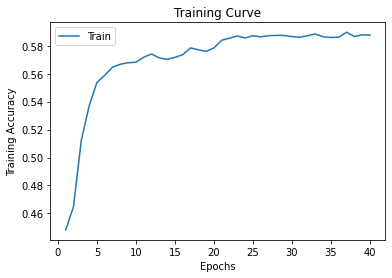

Final Training Accuracy: 0.5876120050847983
Epochs: 40,Learning Rate: 0.0001


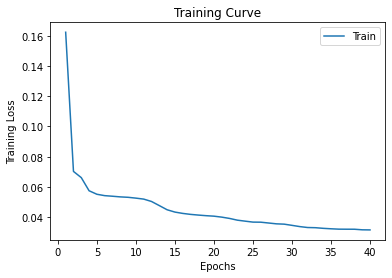

Final Training Loss: 0.031597518923109295


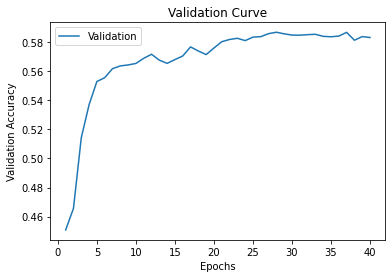

Final Validation Accuracy: 0.5832609953703703
Epochs: 40,Learning Rate: 0.0001


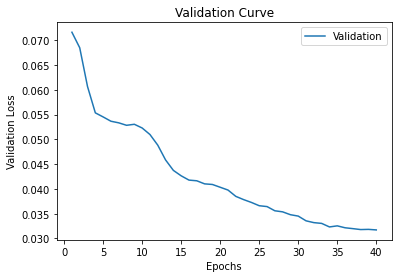

Final Validation Loss: 0.03172510423480648
Final Epochs: 40


In [89]:
batch_size=64
num_epochs = 40
lr = 1e-4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1)
valid_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1)
autoencoder0 = AutoEncoder()
tr_acc,vl_acc,tr_loss,vl_loss,epochs_l,iterations = train(autoencoder0, train_loader, valid_loader, num_epochs=num_epochs, learning_rate=lr)

In [95]:
import time

def simpler_train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #Variables for returning
    tr_acc, vl_acc, tr_loss, vl_loss = 0.0,0.0,0.0,0.0
    start = time.perf_counter()
    for epoch in range(num_epochs):
        loss_total = 0
        counter = 0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_total = loss_total + loss.item()
            counter = counter +1
        #Update plotting things
        tr_acc= get_accuracy(model, train_loader) #Usage of given function
        vl_acc= get_accuracy(model,valid_loader)
        tr_loss= loss_total / (counter+1)
        vl_loss = try_loss(model, valid_loader,criterion)
        
        
        #See the evolution of the model so far
    end = time.perf_counter()
    time_diff = end-start
    #Plot and return
    return tr_acc,vl_acc,tr_loss,vl_loss, time_diff

def print_stats(model_no, lr,bs,num_epochs,tr_acc,vl_acc,tr_loss,val_loss,time_diff):
  print("Model #: {0} ".format(model_no))
  print("Learning Rate: {0} Batch Size: {1} Number of Epochs: {2}".format(lr,bs,num_epochs))
  print("Final Training Accuracy: {0} Final Validation Accuracy: {1} Final Training Loss: {2} Final Validation Loss: {3}".format(tr_acc,vl_acc,tr_loss,val_loss))
  print("Took: {0} seconds".format(time_diff))
  return


In [96]:
#Tuning Learning Rate,Batch Size,Number of Epochs (not included below)
lr = [1e-4,5e-4,1e-3,1e-2]
bs = [64,128,256,512]
ne = [40,40,40,40]

for i in range(4):
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=bs[i], num_workers=1)
  valid_loader = torch.utils.data.DataLoader(val_set, batch_size=bs[i], num_workers=1)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=bs[i], num_workers=1)
  tr_acc,vl_acc,tr_loss,vl_loss, time_diff = simpler_train(autoencoder0, train_loader, valid_loader, num_epochs=ne[i], learning_rate=lr[i])
  print_stats(i, lr[i],bs[i],ne[i],tr_acc,vl_acc,tr_loss,vl_loss,time_diff)


Model #: 0 
Learning Rate: 0.0001 Batch Size: 64 Number of Epochs: 40
Final Training Accuracy: 0.604176355687843 Final Validation Accuracy: 0.6024667245370371 Final Training Loss: 0.02210810739348037 Final Validation Loss: 0.021866381678679218
Took: 270.14461377099724 seconds
Model #: 1 
Learning Rate: 0.0005 Batch Size: 128 Number of Epochs: 40
Final Training Accuracy: 0.6119043189780795 Final Validation Accuracy: 0.6075303819444444 Final Training Loss: 0.020246572996429086 Final Validation Loss: 0.019928157203704923
Took: 184.89031846000216 seconds
Model #: 2 
Learning Rate: 0.001 Batch Size: 256 Number of Epochs: 40
Final Training Accuracy: 0.6063544476482807 Final Validation Accuracy: 0.6016348379629629 Final Training Loss: 0.01872761252829257 Final Validation Loss: 0.01910360804513881
Took: 140.74513391599976 seconds
Model #: 3 
Learning Rate: 0.01 Batch Size: 512 Number of Epochs: 40
Final Training Accuracy: 0.6288949865128826 Final Validation Accuracy: 0.6263382523148148 Final T

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
#These were the hyperparameters I tried:
""""
Model #: 0 
Learning Rate: 0.0001 Batch Size: 64 Number of Epochs: 40
Final Training Accuracy: 0.604176355687843 Final Validation Accuracy: 0.6024667245370371 Final Training Loss: 0.02210810739348037 Final Validation Loss: 0.021866381678679218
Took: 270.14461377099724 seconds
Model #: 1 
Learning Rate: 0.0005 Batch Size: 128 Number of Epochs: 40
Final Training Accuracy: 0.6119043189780795 Final Validation Accuracy: 0.6075303819444444 Final Training Loss: 0.020246572996429086 Final Validation Loss: 0.019928157203704923
Took: 184.89031846000216 seconds
Model #: 2 
Learning Rate: 0.001 Batch Size: 256 Number of Epochs: 40
Final Training Accuracy: 0.6063544476482807 Final Validation Accuracy: 0.6016348379629629 Final Training Loss: 0.01872761252829257 Final Validation Loss: 0.01910360804513881
Took: 140.74513391599976 seconds
Model #: 3 
Learning Rate: 0.01 Batch Size: 512 Number of Epochs: 40
Final Training Accuracy: 0.6288949865128826 Final Validation Accuracy: 0.6263382523148148 Final Training Loss: 0.013195511971622012 Final Validation Loss: 0.011753491684794426
Took: 120.60563576200002 seconds
""""
#All of my hyperparameter settings followed this simple set of rules:
#1.Bigger Learning Rate = Bigger Batch Size
#2.If it stalls for too long, increase learning rate
#3.If it has lower than 0.55 validation accuracy, lower learning rate and batch size, increase number of epochs
#The models above were from my last training batch with Number of Epochs constant at 40 across all models 
#The final model choice is model 3 (the 4th one)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [98]:
test_accuracy = get_accuracy(autoencoder0,test_loader)

In [99]:
print("Test Accuracy is " , test_accuracy)

Test Accuracy is  0.6264105902777778


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [100]:
#To predict a missing feature, the baseline model will look at the most common value of the feature in the training set.
#Get most common feature in df
most_frequent = {}
for col in catcols:
  most_frequent[col] = df.mode()[col].item()

In [107]:
def zero_out_feature_modded(records, feature):
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    #Modified here#####################
    for i in range(stop_index - start_index):
      records[start_index + i] = 0
    ###################################
    return records

def baseline(row):
  for col in catcols:
    if (np.sum(get_onehot(row, col)) == 0):
      freq = str(most_frequent[col]).strip()
      pred = np.zeros(len(cat_values[col]))
      pred[cat_values[col].index(freq)] = 1  #set 1

      for i in range(len(pred)):
        row[cat_index[col] + i] = pred[i]
  return row

def get_accuracy_modded(data_set):
    total = 0
    acc = 0
    #Modified here############
    for col in catcols:
      for row in data_set:
        row_mod = zero_out_feature_modded(np.copy(row), col)
        out = baseline(row_mod)
    ##########################   
        for i in range(out.shape[0]): # record in minibatch
          acc += int(get_feature(out, col) == get_feature(row, col))
          total += 1
    
    return acc/total

In [108]:
baseline_acc = get_accuracy_modded(test_set)

In [109]:
print("Baseline acc is ", baseline_acc)

Baseline acc is  0.4583695023148148


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [110]:
print("The difference in my model's vs the baseline model's test acc is of ",  test_accuracy-baseline_acc)
#The difference is significant = 0.1680 in favor of my model

The difference in my model's vs the baseline model's test acc is of  0.16804108796296297


### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [116]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
dude = test_set[0]
for cathegory in catcols:
  print("{} : {}".format(cathegory,get_categorical_value(get_onehot(dude,cathegory),cathegory)))


work : Private
marriage : Divorced
occupation : Transport-moving
edu : HS-grad
relationship : Not-in-family
sex : Male


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [124]:
test_subject = torch.from_numpy(zero_out_feature_modded(dude, 'edu'))
out = autoencoder0(test_subject)
out = out.detach().numpy()
print(get_categorical_value(get_onehot(out, 'edu'), 'edu'))

HS-grad


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [126]:
test_subject_base = zero_out_feature_modded(dude, 'edu')
out_base = baseline(test_subject_base)
print(get_categorical_value(get_onehot(out, 'edu'), 'edu'))
#This result can seem unexpected, since both models have low accs and the
#classification is indeed correct in both cases, this occurrence happened
#because HS-grad is the most common education level in the dataset on which
#the models (only mine actually) were trained

HS-grad
